## 1. 环境设置

In [16]:
# 环境设置
import sys
from pathlib import Path

# 添加src到路径
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root / 'src'))

print(f"项目根目录: {project_root}")

项目根目录: c:\Users\Quenton\Documents\Github\writtingOCR


In [3]:
# 导入必要的库
import json
import re
import difflib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from paddleocr import PaddleOCR

print("✓ 库导入成功")

c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ 库导入成功


## 2. 定义裁剪区域和辅助函数

In [4]:
# 第1页和第2页的裁剪区域
CROP_REGION_PAGE1 = {
    'x_start': 150,
    'y_start': 360,
    'x_end': 2320,
    'y_end': 3260
}

# 第2页坐标待定（Phase 2）
CROP_REGION_PAGE2 = None

print("第1页裁剪区域:")
print(f"  左上角: ({CROP_REGION_PAGE1['x_start']}, {CROP_REGION_PAGE1['y_start']})")
print(f"  右下角: ({CROP_REGION_PAGE1['x_end']}, {CROP_REGION_PAGE1['y_end']})")
print(f"  尺寸: {CROP_REGION_PAGE1['x_end'] - CROP_REGION_PAGE1['x_start']} x {CROP_REGION_PAGE1['y_end'] - CROP_REGION_PAGE1['y_start']} 像素")

第1页裁剪区域:
  左上角: (150, 360)
  右下角: (2320, 3260)
  尺寸: 2170 x 2900 像素


In [5]:
def crop_image(img_path, crop_region):
    """
    裁剪图片到指定区域
    
    参数:
        img_path: 图片路径
        crop_region: 裁剪区域字典 {x_start, y_start, x_end, y_end}
    
    返回:
        PIL.Image: 裁剪后的图片
    """
    img = Image.open(img_path)
    cropped = img.crop((
        crop_region['x_start'],
        crop_region['y_start'],
        crop_region['x_end'],
        crop_region['y_end']
    ))
    return cropped


def get_crop_region(filename):
    """
    根据文件名自动选择裁剪区域
    
    参数:
        filename: 文件名（如 'sample_01_01.png'）
    
    返回:
        dict: 对应的裁剪区域
    """
    if '_01.png' in filename or '_01_' in filename:
        return CROP_REGION_PAGE1
    elif '_02.png' in filename or '_02_' in filename:
        if CROP_REGION_PAGE2 is None:
            raise ValueError("第2页裁剪区域尚未定义，请先完成 Phase 2")
        return CROP_REGION_PAGE2
    else:
        raise ValueError(f"无法识别文件名格式: {filename}")


print("✓ 裁剪函数定义完成")

✓ 裁剪函数定义完成


## 3. 加载Ground Truth和评估函数

In [6]:
# 读取ground truth
gt_file = project_root / 'data' / 'samples' / '2022 第2題 (冬奧) (8份)_Original' / 'sample_01_01_ground_truth.txt'
with open(gt_file, 'r', encoding='utf-8') as f:
    ground_truth = f.read()

# 清理ground truth: 移除标注标签
gt_clean = re.sub(r'<insert>|</insert>|<\?>', '', ground_truth)
gt_clean = gt_clean.replace('\n', '').replace(' ', '')  # 移除换行和空格

print(f"Ground Truth字符数: {len(gt_clean)}")
print(f"Ground Truth前100字符:\n{gt_clean[:100]}")
print("\n" + "="*60)

Ground Truth字符数: 552
Ground Truth前100字符:
親愛的你：你好！我是一名普通的香港人。首先，請容許我爲自己的俗氣致歉。畢竟我倆素未謀面，再加上我是一名老實人，實在寫不出些精妙絕倫又討好非常的句子，唯有難爲你頂著這俗氣難當的石頭繼續閲讀下去。你或許會



In [7]:
def calculate_accuracy(predicted_text, ground_truth_text):
    """
    计算字符级准确率
    使用序列匹配算法计算相似度
    """
    # 清理预测文本
    pred_clean = predicted_text.replace('\n', '').replace(' ', '')
    gt_clean = ground_truth_text.replace('\n', '').replace(' ', '')
    
    # 使用difflib计算相似度
    matcher = difflib.SequenceMatcher(None, pred_clean, gt_clean)
    similarity = matcher.ratio()
    
    # 计算字符级统计
    total_chars = len(gt_clean)
    matches = sum(block.size for block in matcher.get_matching_blocks())
    
    return {
        'similarity': similarity * 100,  # 百分比
        'total_chars': total_chars,
        'matched_chars': matches,
        'accuracy': (matches / total_chars * 100) if total_chars > 0 else 0
    }


def load_ocr_result(json_path):
    """从JSON文件加载OCR识别结果"""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # 拼接所有识别文本
    text = ''.join(data.get('rec_texts', []))
    return text


print("✓ 评估函数定义完成")

✓ 评估函数定义完成


## Phase 1: 第1页格式测试

### 4. 裁剪测试图片

✓ 图片裁剪完成
  原图尺寸: (2480, 3507)
  裁剪后尺寸: (2170, 2900)
  临时保存位置: c:\Users\Quenton\Documents\Github\writtingOCR\output\temp_cropped.png


C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\572178976.py:22: UserWarning: Glyph 35009 (\N{CJK UNIFIED IDEOGRAPH-88C1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\572178976.py:22: UserWarning: Glyph 21098 (\N{CJK UNIFIED IDEOGRAPH-526A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\572178976.py:22: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\572178976.py:22: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\572178976.py:22: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\572178976.py:22: UserWarning: Glyph 25

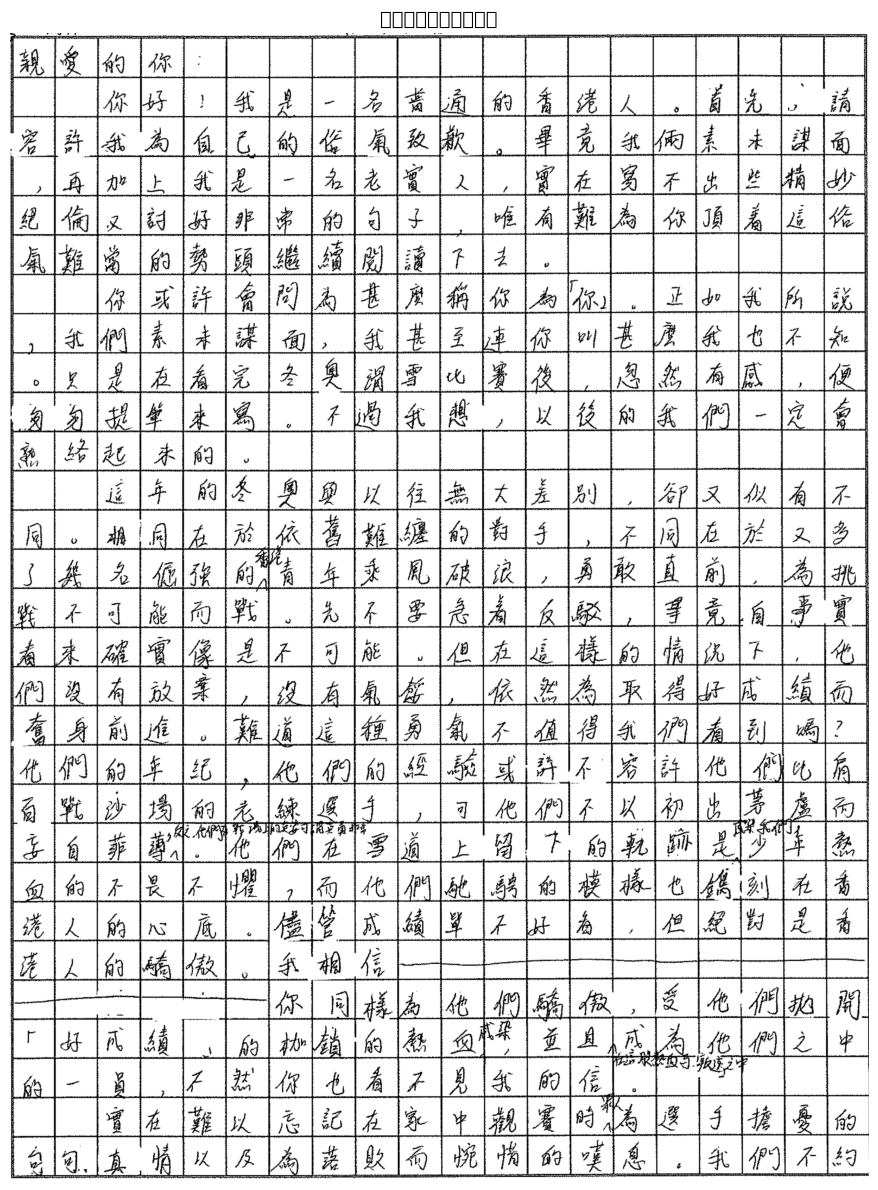

In [8]:
# 测试图片路径
test_img_path = project_root / 'data' / 'samples' / '2022 第2題 (冬奧) (8份)_Original' / 'sample_01_01.png'

# 裁剪图片
cropped_img = crop_image(test_img_path, CROP_REGION_PAGE1)

# 保存裁剪后的图片（临时）
temp_cropped_path = project_root / 'output' / 'temp_cropped.png'
temp_cropped_path.parent.mkdir(parents=True, exist_ok=True)
cropped_img.save(temp_cropped_path)

print(f"✓ 图片裁剪完成")
print(f"  原图尺寸: {Image.open(test_img_path).size}")
print(f"  裁剪后尺寸: {cropped_img.size}")
print(f"  临时保存位置: {temp_cropped_path}")

# 显示裁剪后的图片
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
ax.imshow(cropped_img)
ax.set_title('裁剪后的作文正文区域', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

### 5. 重新运行6个参数配置（裁剪后）

In [10]:
# 创建输出目录
cropped_output_base = project_root / 'output' / 'cropped_ocr_results'
cropped_output_base.mkdir(parents=True, exist_ok=True)

# 定义6个测试配置
test_configs = [
    {
        'name': '1_default',
        'desc': '默认参数',
        'params': {}
    },
    {
        'name': '2_low_thresh',
        'desc': '低检测阈值(0.3)',
        'params': {'text_det_box_thresh': 0.3}
    },
    {
        'name': '3_unclip',
        'desc': '大扩展比例(2.0)',
        'params': {'text_det_unclip_ratio': 2.0}
    },
    {
        'name': '4_combined',
        'desc': '组合调整(0.3+2.0)',
        'params': {'text_det_box_thresh': 0.3, 'text_det_unclip_ratio': 2.0}
    },
    {
        'name': '5_test1',
        'desc': '极低阈值+小扩展(0.2+1.2)',
        'params': {'text_det_box_thresh': 0.2, 'text_det_unclip_ratio': 1.2}
    },
    {
        'name': '6_test2',
        'desc': '中阈值+大扩展(0.4+2.5)',
        'params': {'text_det_box_thresh': 0.4, 'text_det_unclip_ratio': 2.5}
    }
]

print("="*80)
print("开始对裁剪后图片运行6个参数配置")
print("="*80)
print(f"测试图片: {test_img_path.name}")
print(f"裁剪区域: 第1页格式 {CROP_REGION_PAGE1}")
print()

开始对裁剪后图片运行6个参数配置
测试图片: sample_01_01.png
裁剪区域: 第1页格式 {'x_start': 150, 'y_start': 360, 'x_end': 2320, 'y_end': 3260}



In [11]:
# 运行所有配置
results = {}

for i, config in enumerate(test_configs, 1):
    print(f"\n[{i}/6] 测试配置: {config['desc']}")
    print(f"  参数: {config['params'] if config['params'] else '默认'}")
    
    # 创建输出目录
    output_dir = cropped_output_base / config['name']
    output_dir.mkdir(exist_ok=True)
    
    try:
        # 初始化OCR
        ocr = PaddleOCR(
            lang='ch',
            use_doc_orientation_classify=False,
            use_doc_unwarping=False,
            use_textline_orientation=False,
            **config['params']
        )
        
        # OCR识别（使用临时裁剪图片）
        result = ocr.predict(input=str(temp_cropped_path))
        
        # 保存可视化结果
        result[0].save_to_img(str(output_dir))
        result[0].save_to_json(str(output_dir))
        
        # 获取识别文本数量
        num_texts = len(result[0]['rec_texts'])
        results[config['name']] = {
            'desc': config['desc'],
            'num_texts': num_texts,
            'output_dir': output_dir
        }
        
        print(f"  ✓ 完成 - 识别到 {num_texts} 个文字区域")
        
    except Exception as e:
        print(f"  ✗ 失败: {e}")
        results[config['name']] = {'error': str(e)}

print("\n" + "="*80)
print("所有配置测试完成")
print("="*80)

Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_det`.
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_det`.



[1/6] 测试配置: 默认参数
  参数: 默认


Creating model: ('PP-OCRv5_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_det`.


  ✓ 完成 - 识别到 167 个文字区域

[2/6] 测试配置: 低检测阈值(0.3)
  参数: {'text_det_box_thresh': 0.3}


Creating model: ('PP-OCRv5_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_det`.


  ✓ 完成 - 识别到 178 个文字区域

[3/6] 测试配置: 大扩展比例(2.0)
  参数: {'text_det_unclip_ratio': 2.0}


Creating model: ('PP-OCRv5_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_det`.


  ✓ 完成 - 识别到 167 个文字区域

[4/6] 测试配置: 组合调整(0.3+2.0)
  参数: {'text_det_box_thresh': 0.3, 'text_det_unclip_ratio': 2.0}


Creating model: ('PP-OCRv5_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_det`.


  ✓ 完成 - 识别到 178 个文字区域

[5/6] 测试配置: 极低阈值+小扩展(0.2+1.2)
  参数: {'text_det_box_thresh': 0.2, 'text_det_unclip_ratio': 1.2}


Creating model: ('PP-OCRv5_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_det`.


  ✓ 完成 - 识别到 178 个文字区域

[6/6] 测试配置: 中阈值+大扩展(0.4+2.5)
  参数: {'text_det_box_thresh': 0.4, 'text_det_unclip_ratio': 2.5}


Creating model: ('PP-OCRv5_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.


  ✓ 完成 - 识别到 178 个文字区域

所有配置测试完成


### 6. 评估准确率（裁剪后）

In [12]:
# 评估所有配置的准确率
accuracy_results = {}

print("="*80)
print("OCR准确率评估结果（裁剪后）")
print("="*80)
print(f"测试图片: sample_01_01.png (裁剪至正文区域)")
print(f"Ground Truth字符数: {len(gt_clean)}")
print("\n")

for config_name, result_info in results.items():
    if 'error' in result_info:
        print(f"⚠️  {result_info['desc']}: 测试失败")
        continue
    
    # 查找JSON文件
    json_file = result_info['output_dir'] / 'temp_cropped_res.json'
    
    if not json_file.exists():
        print(f"⚠️  {result_info['desc']}: JSON文件不存在")
        continue
    
    try:
        predicted_text = load_ocr_result(json_file)
        metrics = calculate_accuracy(predicted_text, gt_clean)
        accuracy_results[config_name] = {
            'desc': result_info['desc'],
            **metrics
        }
        
        print(f"【{result_info['desc']}】")
        text_length = len(predicted_text.replace(' ', '').replace('\n', ''))
        print(f"  识别字符数: {text_length}")
        print(f"  匹配字符数: {metrics['matched_chars']}")
        print(f"  准确率: {metrics['accuracy']:.2f}%")
        print(f"  相似度: {metrics['similarity']:.2f}%")
        print()
        
    except Exception as e:
        print(f"✗ {result_info['desc']}: 评估失败 - {e}")
        print()

print("="*80)

OCR准确率评估结果（裁剪后）
测试图片: sample_01_01.png (裁剪至正文区域)
Ground Truth字符数: 552


【默认参数】
  识别字符数: 453
  匹配字符数: 271
  准确率: 49.09%
  相似度: 53.93%

【低检测阈值(0.3)】
  识别字符数: 490
  匹配字符数: 293
  准确率: 53.08%
  相似度: 56.24%

【大扩展比例(2.0)】
  识别字符数: 449
  匹配字符数: 272
  准确率: 49.28%
  相似度: 54.35%

【组合调整(0.3+2.0)】
  识别字符数: 484
  匹配字符数: 296
  准确率: 53.62%
  相似度: 57.14%

【极低阈值+小扩展(0.2+1.2)】
  识别字符数: 490
  匹配字符数: 293
  准确率: 53.08%
  相似度: 56.24%

【中阈值+大扩展(0.4+2.5)】
  识别字符数: 488
  匹配字符数: 277
  准确率: 50.18%
  相似度: 53.27%



### 7. 可视化对比（裁剪前后）

C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\1008376266.py:33: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\1008376266.py:33: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\1008376266.py:33: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\1008376266.py:33: UserWarning: Glyph 40664 (\N{CJK UNIFIED IDEOGRAPH-9ED8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\1008376266.py:33: UserWarning: Glyph 35748 (\N{CJK UNIFIED IDEOGRAPH-8BA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\1008376266.py:33: UserWarning: Gl

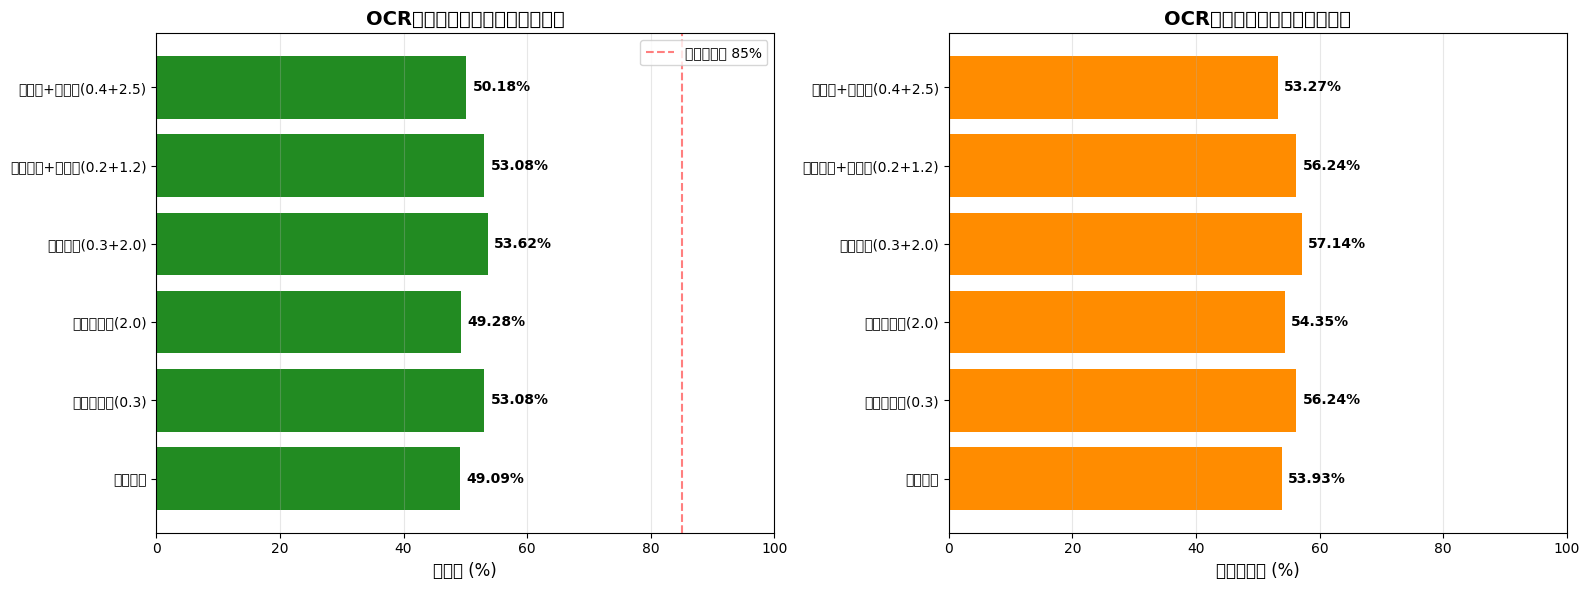


🏆 最佳配置: 组合调整(0.3+2.0)
   准确率: 53.62%
   相似度: 57.14%

⚠️  准确率 53.62% 未达到85%目标
   建议: 分析错误类型，考虑额外预处理（如格子线去除）


In [13]:
# 可视化对比：裁剪后的准确率
if accuracy_results:
    config_names = [info['desc'] for info in accuracy_results.values()]
    accuracies = [info['accuracy'] for info in accuracy_results.values()]
    similarities = [info['similarity'] for info in accuracy_results.values()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 准确率对比
    bars1 = ax1.barh(config_names, accuracies, color='forestgreen')
    ax1.set_xlabel('准确率 (%)', fontsize=12)
    ax1.set_title('OCR字符级准确率对比（裁剪后）', fontsize=14, fontweight='bold')
    ax1.set_xlim(0, 100)
    ax1.grid(axis='x', alpha=0.3)
    ax1.axvline(x=85, color='red', linestyle='--', alpha=0.5, label='目标准确率 85%')
    ax1.legend()
    
    # 在柱状图上标注数值
    for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
        ax1.text(acc + 1, i, f'{acc:.2f}%', va='center', fontsize=10, fontweight='bold')
    
    # 相似度对比
    bars2 = ax2.barh(config_names, similarities, color='darkorange')
    ax2.set_xlabel('序列相似度 (%)', fontsize=12)
    ax2.set_title('OCR序列相似度对比（裁剪后）', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 100)
    ax2.grid(axis='x', alpha=0.3)
    
    # 在柱状图上标注数值
    for i, (bar, sim) in enumerate(zip(bars2, similarities)):
        ax2.text(sim + 1, i, f'{sim:.2f}%', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 输出最佳配置
    best_config = max(accuracy_results.items(), key=lambda x: x[1]['accuracy'])
    print(f"\n🏆 最佳配置: {best_config[1]['desc']}")
    print(f"   准确率: {best_config[1]['accuracy']:.2f}%")
    print(f"   相似度: {best_config[1]['similarity']:.2f}%")
    
    # 判断是否达到目标
    if best_config[1]['accuracy'] >= 85:
        print("\n✅ 准确率已达到85%目标！可以进入Phase 2")
    else:
        print(f"\n⚠️  准确率 {best_config[1]['accuracy']:.2f}% 未达到85%目标")
        print("   建议: 分析错误类型，考虑额外预处理（如格子线去除）")
else:
    print("⚠️  没有可用的评估结果")

### 8. Phase 1 小结

In [14]:
# 生成Phase 1测试报告
if accuracy_results:
    best = max(accuracy_results.items(), key=lambda x: x[1]['accuracy'])
    avg_acc = np.mean([info['accuracy'] for info in accuracy_results.values()])
    
    report = f"""
{'='*80}
Phase 1 测试报告 - 第1页格式裁剪后OCR
{'='*80}

测试配置:
  - 测试图片: sample_01_01.png
  - 裁剪区域: 第1页格式 (150, 360, 2320, 3260)
  - 参数配置数: {len(accuracy_results)}
  - Ground Truth字符数: {len(gt_clean)}

测试结果:
  - 最佳配置: {best[1]['desc']}
  - 最高准确率: {best[1]['accuracy']:.2f}%
  - 平均准确率: {avg_acc:.2f}%

结论:
  - 裁剪方案{'有效' if best[1]['accuracy'] >= 85 else '需要进一步优化'}
  - {'✅ 可以进入Phase 2（第2页坐标确定）' if best[1]['accuracy'] >= 85 else '⚠️ 建议先分析错误原因'}

日期: {__import__('datetime').datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*80}
    """
    
    print(report)
    
    # 保存报告到文件
    report_file = cropped_output_base / 'phase1_report.txt'
    with open(report_file, 'w', encoding='utf-8') as f:
        f.write(report)
    print(f"\n报告已保存到: {report_file}")
else:
    print("⚠️  无法生成报告 - 没有评估结果")


Phase 1 测试报告 - 第1页格式裁剪后OCR

测试配置:
  - 测试图片: sample_01_01.png
  - 裁剪区域: 第1页格式 (150, 360, 2320, 3260)
  - 参数配置数: 6
  - Ground Truth字符数: 552

测试结果:
  - 最佳配置: 组合调整(0.3+2.0)
  - 最高准确率: 53.62%
  - 平均准确率: 51.39%

结论:
  - 裁剪方案需要进一步优化
  - ⚠️ 建议先分析错误原因

日期: 2025-11-25 12:02:40
    

报告已保存到: c:\Users\Quenton\Documents\Github\writtingOCR\output\cropped_ocr_results\phase1_report.txt


### 9. 详细错误分析

深入分析OCR识别错误的具体原因

In [13]:
# 加载最佳配置的OCR结果进行详细分析
if accuracy_results:
    best_config_name = max(accuracy_results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_desc = accuracy_results[best_config_name]['desc']
    
    # 加载OCR识别文本
    json_file = results[best_config_name]['output_dir'] / 'temp_cropped_res.json'
    predicted_text = load_ocr_result(json_file)
    pred_clean = predicted_text.replace('\n', '').replace(' ', '')
    
    print("="*80)
    print(f"详细错误分析 - {best_desc}")
    print("="*80)
    print(f"\nGround Truth: {len(gt_clean)} 字符")
    print(f"OCR识别结果: {len(pred_clean)} 字符")
    print(f"字符数差异: {len(pred_clean) - len(gt_clean)} ({'多了' if len(pred_clean) > len(gt_clean) else '少了'} {abs(len(pred_clean) - len(gt_clean))} 个字符)")
    print("\n" + "-"*80)
    
    # 显示前300字符对比
    print("\n【Ground Truth 前300字符】")
    print(gt_clean[:300])
    print("\n" + "-"*80)
    print("\n【OCR识别 前300字符】")
    print(pred_clean[:300])
    print("\n" + "-"*80)
    
else:
    print("⚠️  没有可用的评估结果")

详细错误分析 - 组合调整(0.3+2.0)

Ground Truth: 552 字符
OCR识别结果: 484 字符
字符数差异: -68 (少了 68 个字符)

--------------------------------------------------------------------------------

【Ground Truth 前300字符】
親愛的你：你好！我是一名普通的香港人。首先，請容許我爲自己的俗氣致歉。畢竟我倆素未謀面，再加上我是一名老實人，實在寫不出些精妙絕倫又討好非常的句子，唯有難爲你頂著這俗氣難當的石頭繼續閲讀下去。你或許會問爲甚麽稱你爲「你」。正如我所説，我們素未謀面，我甚至連你叫甚麽我也不知。只是在看完冬奧滑雪比賽後，忽然有感，便匆匆提筆來寫。不過我想，以後的我們一定會熟絡起來的。這年的冬奧與以往五大差別，卻又似有不同。相同在依舊難纏的對手，不同在於又多了幾名倔强的香港青年乘風破浪，勇敢直前，為挑戰不可能而戰。先不要急著反駁，畢竟自事實看來確實像是不可能。但在則好樣的情況下，他們沒有放棄，沒有氣餒，依然為取得好成

--------------------------------------------------------------------------------

【OCR识别 前300字符】
親愛的你你好！我名普通的香港葡是先請-T0D素許我為自己的俗氣致歉畢我俩未谋容面上我是一名老寞曾在易不出精妙再加人些唯有難為你頂着又时好非常的句子這纪倫俗難當的勢頭繼續閱讀下去氣你或許會問為甚麼稱你為你正如我所说U們素未謀面，我甚至連你叫甚麼我也不我知是在看完冬奥谓雪比赛忽然有感便只後0以後的我們一定提第来寫不過我想，會匆勿熟络起未的年的冬奥以往無大差這别卻又似有不同在於y相同在於依舊難纏的對手不又同U幾名倔强的青年乘风破浪，勇敢直前為~挑*K要急着反竟自事實不可能而戰戰，可能這樣的情说下看未確實像是不但在他7們没有放案，沒有氣依然為取得好成績而奮身前進難道這種勇氣不值得我們看到?U们的年纪或

--------------------------------------------------------------------------------


In [14]:
# 使用difflib生成详细的文本差异对比
if accuracy_results:
    print("\n" + "="*80)
    print("详细文本差异分析（前500字符范围）")
    print("="*80)
    
    # 使用SequenceMatcher获取详细匹配信息
    matcher = difflib.SequenceMatcher(None, pred_clean, gt_clean)
    
    print("\n【匹配块统计】")
    matching_blocks = matcher.get_matching_blocks()
    print(f"总匹配块数: {len(matching_blocks)}")
    print(f"最大连续匹配长度: {max(block.size for block in matching_blocks) if matching_blocks else 0}")
    
    # 显示opcodes（操作码）
    print("\n【差异操作序列（前20个操作）】")
    opcodes = matcher.get_opcodes()
    
    for i, (tag, i1, i2, j1, j2) in enumerate(opcodes[:20]):
        if tag == 'equal':
            print(f"{i+1}. 匹配: OCR[{i1}:{i2}] = GT[{j1}:{j2}] (长度{i2-i1})")
            if i2 - i1 <= 20:  # 只显示短匹配的内容
                print(f"   内容: '{pred_clean[i1:i2]}'")
        elif tag == 'replace':
            print(f"{i+1}. 替换: OCR[{i1}:{i2}] '{pred_clean[i1:i2][:30]}...' → GT[{j1}:{j2}] '{gt_clean[j1:j2][:30]}...'")
        elif tag == 'delete':
            print(f"{i+1}. OCR多余: OCR[{i1}:{i2}] '{pred_clean[i1:i2][:30]}...' (OCR多识别了)")
        elif tag == 'insert':
            print(f"{i+1}. OCR缺失: GT[{j1}:{j2}] '{gt_clean[j1:j2][:30]}...' (OCR漏掉了)")
    
    if len(opcodes) > 20:
        print(f"\n... 还有 {len(opcodes) - 20} 个操作未显示")
    
    # 统计错误类型
    replace_count = sum(1 for tag, _, _, _, _ in opcodes if tag == 'replace')
    delete_count = sum(1 for tag, _, _, _, _ in opcodes if tag == 'delete')
    insert_count = sum(1 for tag, _, _, _, _ in opcodes if tag == 'insert')
    
    print("\n" + "-"*80)
    print("【错误类型统计】")
    print(f"替换错误（识别错了）: {replace_count} 处")
    print(f"多余字符（OCR多识别）: {delete_count} 处")
    print(f"缺失字符（OCR漏检）: {insert_count} 处")
    print(f"总错误数: {replace_count + delete_count + insert_count}")
    
else:
    print("⚠️  没有可用的评估结果")


详细文本差异分析（前500字符范围）

【匹配块统计】
总匹配块数: 91
最大连续匹配长度: 13

【差异操作序列（前20个操作）】
1. 匹配: OCR[0:4] = GT[0:4] (长度4)
   内容: '親愛的你'
2. OCR缺失: GT[4:5] '：...' (OCR漏掉了)
3. 匹配: OCR[4:8] = GT[5:9] (长度4)
   内容: '你好！我'
4. OCR缺失: GT[9:11] '是一...' (OCR漏掉了)
5. 匹配: OCR[8:14] = GT[11:17] (长度6)
   内容: '名普通的香港'
6. 替换: OCR[14:16] '葡是...' → GT[17:20] '人。首...'
7. 匹配: OCR[16:17] = GT[20:21] (长度1)
   内容: '先'
8. OCR缺失: GT[21:22] '，...' (OCR漏掉了)
9. 匹配: OCR[17:18] = GT[22:23] (长度1)
   内容: '請'
10. 替换: OCR[18:23] '-T0D素...' → GT[23:24] '容...'
11. 匹配: OCR[23:25] = GT[24:26] (长度2)
   内容: '許我'
12. 替换: OCR[25:26] '為...' → GT[26:27] '爲...'
13. 匹配: OCR[26:33] = GT[27:34] (长度7)
   内容: '自己的俗氣致歉'
14. OCR缺失: GT[34:35] '。...' (OCR漏掉了)
15. 匹配: OCR[33:34] = GT[35:36] (长度1)
   内容: '畢'
16. 替换: OCR[34:36] '我俩...' → GT[36:40] '竟我倆素...'
17. 匹配: OCR[36:37] = GT[40:41] (长度1)
   内容: '未'
18. 替换: OCR[37:39] '谋容...' → GT[41:42] '謀...'
19. 匹配: OCR[39:40] = GT[42:43] (长度1)
   内容: '面'
20. OCR缺失: GT[43:46] '，再加...' (OCR漏掉了)

... 还有 160 个操作未显示

--------

In [15]:
# 分析OCR识别的具体内容（从JSON查看原始识别结果）
if accuracy_results:
    print("\n" + "="*80)
    print("OCR原始识别结果分析")
    print("="*80)
    
    json_file = results[best_config_name]['output_dir'] / 'temp_cropped_res.json'
    with open(json_file, 'r', encoding='utf-8') as f:
        ocr_data = json.load(f)
    
    rec_texts = ocr_data.get('rec_texts', [])
    rec_scores = ocr_data.get('rec_scores', [])
    
    print(f"\n检测到的文字区域数: {len(rec_texts)}")
    print(f"\n【前30个识别结果】")
    print("-"*80)
    
    for i, (text, score) in enumerate(zip(rec_texts[:30], rec_scores[:30])):
        print(f"{i+1:3d}. '{text}' (置信度: {score:.3f})")
    
    if len(rec_texts) > 30:
        print(f"\n... 还有 {len(rec_texts) - 30} 个识别结果未显示")
    
    # 置信度分析
    print("\n" + "-"*80)
    print("【置信度统计】")
    print(f"平均置信度: {np.mean(rec_scores):.3f}")
    print(f"最低置信度: {np.min(rec_scores):.3f}")
    print(f"最高置信度: {np.max(rec_scores):.3f}")
    print(f"置信度 < 0.7 的区域: {sum(1 for s in rec_scores if s < 0.7)} 个 ({sum(1 for s in rec_scores if s < 0.7)/len(rec_scores)*100:.1f}%)")
    print(f"置信度 < 0.5 的区域: {sum(1 for s in rec_scores if s < 0.5)} 个 ({sum(1 for s in rec_scores if s < 0.5)/len(rec_scores)*100:.1f}%)")
    
    # 识别文本长度分析
    text_lengths = [len(t) for t in rec_texts]
    print("\n【识别文本长度分析】")
    print(f"平均每个区域字符数: {np.mean(text_lengths):.1f}")
    print(f"单字符区域数: {sum(1 for l in text_lengths if l == 1)} 个")
    print(f"2-5字符区域数: {sum(1 for l in text_lengths if 2 <= l <= 5)} 个")
    print(f"6-10字符区域数: {sum(1 for l in text_lengths if 6 <= l <= 10)} 个")
    print(f"10字符以上区域数: {sum(1 for l in text_lengths if l > 10)} 个")
    
    print("\n" + "="*80)
    
else:
    print("⚠️  没有可用的评估结果")


OCR原始识别结果分析

检测到的文字区域数: 178

【前30个识别结果】
--------------------------------------------------------------------------------
  1. '親愛的你' (置信度: 0.970)
  2. '你好！我' (置信度: 0.889)
  3. '名普通的香港' (置信度: 0.948)
  4. '葡' (置信度: 0.153)
  5. '是' (置信度: 0.997)
  6. '先' (置信度: 0.739)
  7. '請' (置信度: 0.934)
  8. '-' (置信度: 0.357)
  9. 'T' (置信度: 0.516)
 10. '0' (置信度: 0.673)
 11. 'D' (置信度: 0.198)
 12. '' (置信度: 0.000)
 13. '素' (置信度: 0.840)
 14. '許我為自己的俗氣致歉' (置信度: 0.809)
 15. '畢' (置信度: 0.724)
 16. '我俩' (置信度: 0.731)
 17. '未' (置信度: 0.995)
 18. '谋' (置信度: 0.735)
 19. '容' (置信度: 0.910)
 20. '面' (置信度: 0.996)
 21. '上我是一名老寞' (置信度: 0.855)
 22. '曾在易不出' (置信度: 0.786)
 23. '精' (置信度: 0.994)
 24. '妙' (置信度: 0.977)
 25. '再' (置信度: 0.998)
 26. '加' (置信度: 0.996)
 27. '人' (置信度: 0.843)
 28. '些' (置信度: 0.598)
 29. '唯有難為你頂着' (置信度: 0.824)
 30. '又时好非常的句子' (置信度: 0.758)

... 还有 148 个识别结果未显示

--------------------------------------------------------------------------------
【置信度统计】
平均置信度: 0.717
最低置信度: 0.000
最高置信度: 0.998
置信度 < 0.7 的区域: 59 个 (33.1

---

## Phase 2: 第2页坐标确定 (待实施)

完成Phase 1后，运行以下步骤确定第2页的裁剪坐标

In [ ]:
# Phase 2 待实施
# 1. 显示 sample_01_02.png 带坐标网格
# 2. 用户标注第2页裁剪坐标
# 3. 更新 CROP_REGION_PAGE2
# 4. 验证裁剪效果

print("Phase 2 尚未实施")
print("请在完成Phase 1并确认准确率达标后再继续")

## 10. 竖线删除效果验证

测试删除竖线对OCR准确率的影响

In [20]:
# 对比测试: 原图 vs 删除竖线后的图片
print("="*80)
print("竖线删除效果对比实验")
print("="*80)

# 测试图片路径
test_images = {
    '原图（有竖线）': project_root / 'output' / 'temp_cropped.png',
    '删除竖线（v3_width9）': project_root / 'output' / 'temp_cropped_v3_width9.png',
    '两次迭代删除（two_pass）': project_root / 'output' / 'temp_cropped_two_pass.png'
}

# 检查文件是否存在
for name, path in test_images.items():
    if path.exists():
        print(f"✓ {name}: {path.name}")
    else:
        print(f"✗ {name}: 文件不存在 - {path}")

print("\n将使用最佳OCR配置: text_det_box_thresh=0.3 + text_det_unclip_ratio=2.0")
print("="*80)

竖线删除效果对比实验
✓ 原图（有竖线）: temp_cropped.png
✓ 删除竖线（v3_width9）: temp_cropped_v3_width9.png
✓ 两次迭代删除（two_pass）: temp_cropped_two_pass.png

将使用最佳OCR配置: text_det_box_thresh=0.3 + text_det_unclip_ratio=2.0


In [21]:
# 初始化OCR(使用最佳配置)
ocr_best = PaddleOCR(
    lang='ch',
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=False,
    text_det_box_thresh=0.3,
    text_det_unclip_ratio=2.0
)

# 对两张图片分别进行OCR
ocr_results = {}

# 创建输出目录
output_dir = project_root / 'output' / 'vertical_line_comparison'
output_dir.mkdir(parents=True, exist_ok=True)

for name, img_path in test_images.items():
    if not img_path.exists():
        print(f"跳过 {name}: 文件不存在")
        continue
    
    print(f"\n处理: {name}")
    print("-" * 60)
    
    # OCR识别
    result = ocr_best.predict(input=str(img_path))
    res = result[0]
    
    # 保存可视化结果和JSON文件
    # 为每个版本创建子目录
    version_dir = output_dir / name.replace('（', '_').replace('）', '').replace(' ', '_')
    version_dir.mkdir(exist_ok=True)
    
    res.save_to_img(str(version_dir))
    res.save_to_json(str(version_dir))
    print(f"  ✓ 结果已保存到: {version_dir}")
    
    # 提取文本
    recognized_text = ''.join(res['rec_texts'])
    
    # 统计信息
    num_boxes = len(res['rec_texts'])
    single_char_boxes = sum(1 for text in res['rec_texts'] if len(text) == 1)
    single_char_ratio = (single_char_boxes / num_boxes * 100) if num_boxes > 0 else 0
    
    # 低置信度统计
    low_conf_count = sum(1 for score in res['rec_scores'] if score < 0.7)
    very_low_conf_count = sum(1 for score in res['rec_scores'] if score < 0.5)
    
    print(f"  检测框数: {num_boxes}")
    print(f"  单字符框: {single_char_boxes} ({single_char_ratio:.1f}%)")
    print(f"  识别字符数: {len(recognized_text)}")
    print(f"  置信度<0.7: {low_conf_count} ({low_conf_count/num_boxes*100:.1f}%)")
    print(f"  置信度<0.5: {very_low_conf_count} ({very_low_conf_count/num_boxes*100:.1f}%)")
    
    ocr_results[name] = {
        'result': res,
        'text': recognized_text,
        'num_boxes': num_boxes,
        'single_char_boxes': single_char_boxes,
        'single_char_ratio': single_char_ratio,
        'low_conf_count': low_conf_count,
        'very_low_conf_count': very_low_conf_count
    }

print("\n" + "="*80)
print("OCR处理完成")
print(f"所有结果保存在: {output_dir}")
print("="*80)

Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_det`.
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
Creating model: ('PP-OCRv5_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.



处理: 原图（有竖线）
------------------------------------------------------------
  ✓ 结果已保存到: c:\Users\Quenton\Documents\Github\writtingOCR\output\vertical_line_comparison\原图_有竖线
  检测框数: 178
  单字符框: 110 (61.8%)
  识别字符数: 484
  置信度<0.7: 59 (33.1%)
  置信度<0.5: 40 (22.5%)

处理: 删除竖线（v3_width9）
------------------------------------------------------------
  ✓ 结果已保存到: c:\Users\Quenton\Documents\Github\writtingOCR\output\vertical_line_comparison\原图_有竖线
  检测框数: 178
  单字符框: 110 (61.8%)
  识别字符数: 484
  置信度<0.7: 59 (33.1%)
  置信度<0.5: 40 (22.5%)

处理: 删除竖线（v3_width9）
------------------------------------------------------------
  ✓ 结果已保存到: c:\Users\Quenton\Documents\Github\writtingOCR\output\vertical_line_comparison\删除竖线_v3_width9
  检测框数: 83
  单字符框: 31 (37.3%)
  识别字符数: 497
  置信度<0.7: 40 (48.2%)
  置信度<0.5: 23 (27.7%)

处理: 两次迭代删除（two_pass）
------------------------------------------------------------
  ✓ 结果已保存到: c:\Users\Quenton\Documents\Github\writtingOCR\output\vertical_line_comparison\删除竖线_v3_width9
  检测框数: 83

In [22]:
# 计算准确率
print("="*80)
print("准确率评估")
print("="*80)

comparison_results = {}

for name, ocr_data in ocr_results.items():
    print(f"\n【{name}】")
    print("-" * 60)
    
    # 计算准确率
    metrics = calculate_accuracy(ocr_data['text'], gt_clean)
    comparison_results[name] = {**ocr_data, **metrics}
    
    print(f"Ground Truth字符数: {metrics['total_chars']}")
    print(f"识别字符数: {len(ocr_data['text'])}")
    print(f"匹配字符数: {metrics['matched_chars']}")
    print(f"准确率: {metrics['accuracy']:.2f}%")
    print(f"相似度: {metrics['similarity']:.2f}%")

print("\n" + "="*80)
print("评估完成")
print("="*80)

准确率评估

【原图（有竖线）】
------------------------------------------------------------
Ground Truth字符数: 552
识别字符数: 484
匹配字符数: 296
准确率: 53.62%
相似度: 57.14%

【删除竖线（v3_width9）】
------------------------------------------------------------
Ground Truth字符数: 552
识别字符数: 497
匹配字符数: 363
准确率: 65.76%
相似度: 69.21%

【两次迭代删除（two_pass）】
------------------------------------------------------------
Ground Truth字符数: 552
识别字符数: 478
匹配字符数: 346
准确率: 62.68%
相似度: 67.18%

评估完成


In [23]:
# 对比表格和可视化
import pandas as pd

# 创建对比表格
comparison_data = []
for name, data in comparison_results.items():
    comparison_data.append({
        '版本': name,
        '检测框数': data['num_boxes'],
        '单字符框数': data['single_char_boxes'],
        '单字符框占比': f"{data['single_char_ratio']:.1f}%",
        '识别字符数': len(data['text']),
        '匹配字符数': data['matched_chars'],
        '准确率': f"{data['accuracy']:.2f}%",
        '相似度': f"{data['similarity']:.2f}%",
        '低置信度(<0.7)': f"{data['low_conf_count']} ({data['low_conf_count']/data['num_boxes']*100:.1f}%)"
    })

df_comparison = pd.DataFrame(comparison_data)

print("="*80)
print("对比结果汇总")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)

# 计算改善幅度
if len(comparison_results) >= 2:
    results_list = list(comparison_results.items())
    original_name, original = results_list[0]
    
    print("\n改善分析:")
    print("-" * 60)
    
    # 对比每个处理版本与原图
    for i in range(1, len(results_list)):
        processed_name, processed = results_list[i]
        print(f"\n【{processed_name} vs {original_name}】")
        print(f"  检测框数: {original['num_boxes']} → {processed['num_boxes']} ({processed['num_boxes'] - original['num_boxes']:+d})")
        print(f"  单字符框: {original['single_char_boxes']} → {processed['single_char_boxes']} ({processed['single_char_boxes'] - original['single_char_boxes']:+d})")
        print(f"  单字符框占比: {original['single_char_ratio']:.1f}% → {processed['single_char_ratio']:.1f}% ({processed['single_char_ratio'] - original['single_char_ratio']:+.1f}%)")
        print(f"  准确率: {original['accuracy']:.2f}% → {processed['accuracy']:.2f}% ({processed['accuracy'] - original['accuracy']:+.2f}%)")
    
    # 如果有3个版本，额外对比两个处理方法
    if len(results_list) == 3:
        method1_name, method1 = results_list[1]
        method2_name, method2 = results_list[2]
        print(f"\n【{method2_name} vs {method1_name}】")
        print(f"  准确率: {method1['accuracy']:.2f}% → {method2['accuracy']:.2f}% ({method2['accuracy'] - method1['accuracy']:+.2f}%)")
        print(f"  单字符框占比: {method1['single_char_ratio']:.1f}% → {method2['single_char_ratio']:.1f}% ({method2['single_char_ratio'] - method1['single_char_ratio']:+.1f}%)")
        
        # 判断哪个方法更好
        if method2['accuracy'] > method1['accuracy']:
            print(f"  ✓ {method2_name} 更优")
        elif method2['accuracy'] < method1['accuracy']:
            print(f"  ✓ {method1_name} 更优")
        else:
            print(f"  ≈ 两种方法效果相当")
    
    print("="*80)

对比结果汇总
              版本  检测框数  单字符框数 单字符框占比  识别字符数  匹配字符数    准确率    相似度 低置信度(<0.7)
         原图（有竖线）   178    110  61.8%    484    296 53.62% 57.14% 59 (33.1%)
 删除竖线（v3_width9）    83     31  37.3%    497    363 65.76% 69.21% 40 (48.2%)
两次迭代删除（two_pass）    79     28  35.4%    478    346 62.68% 67.18% 37 (46.8%)

改善分析:
------------------------------------------------------------

【删除竖线（v3_width9） vs 原图（有竖线）】
  检测框数: 178 → 83 (-95)
  单字符框: 110 → 31 (-79)
  单字符框占比: 61.8% → 37.3% (-24.4%)
  准确率: 53.62% → 65.76% (+12.14%)

【两次迭代删除（two_pass） vs 原图（有竖线）】
  检测框数: 178 → 79 (-99)
  单字符框: 110 → 28 (-82)
  单字符框占比: 61.8% → 35.4% (-26.4%)
  准确率: 53.62% → 62.68% (+9.06%)

【两次迭代删除（two_pass） vs 删除竖线（v3_width9）】
  准确率: 65.76% → 62.68% (-3.08%)
  单字符框占比: 37.3% → 35.4% (-1.9%)
  ✓ 删除竖线（v3_width9） 更优


C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\1390281175.py:61: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\1390281175.py:61: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\1390281175.py:61: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\1390281175.py:61: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\1390281175.py:61: UserWarning: Glyph 31446 (\N{CJK UNIFIED IDEOGRAPH-7AD6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Quenton\AppData\Local\Temp\ipykernel_22624\1390281175.py:61: UserWarning: Gl

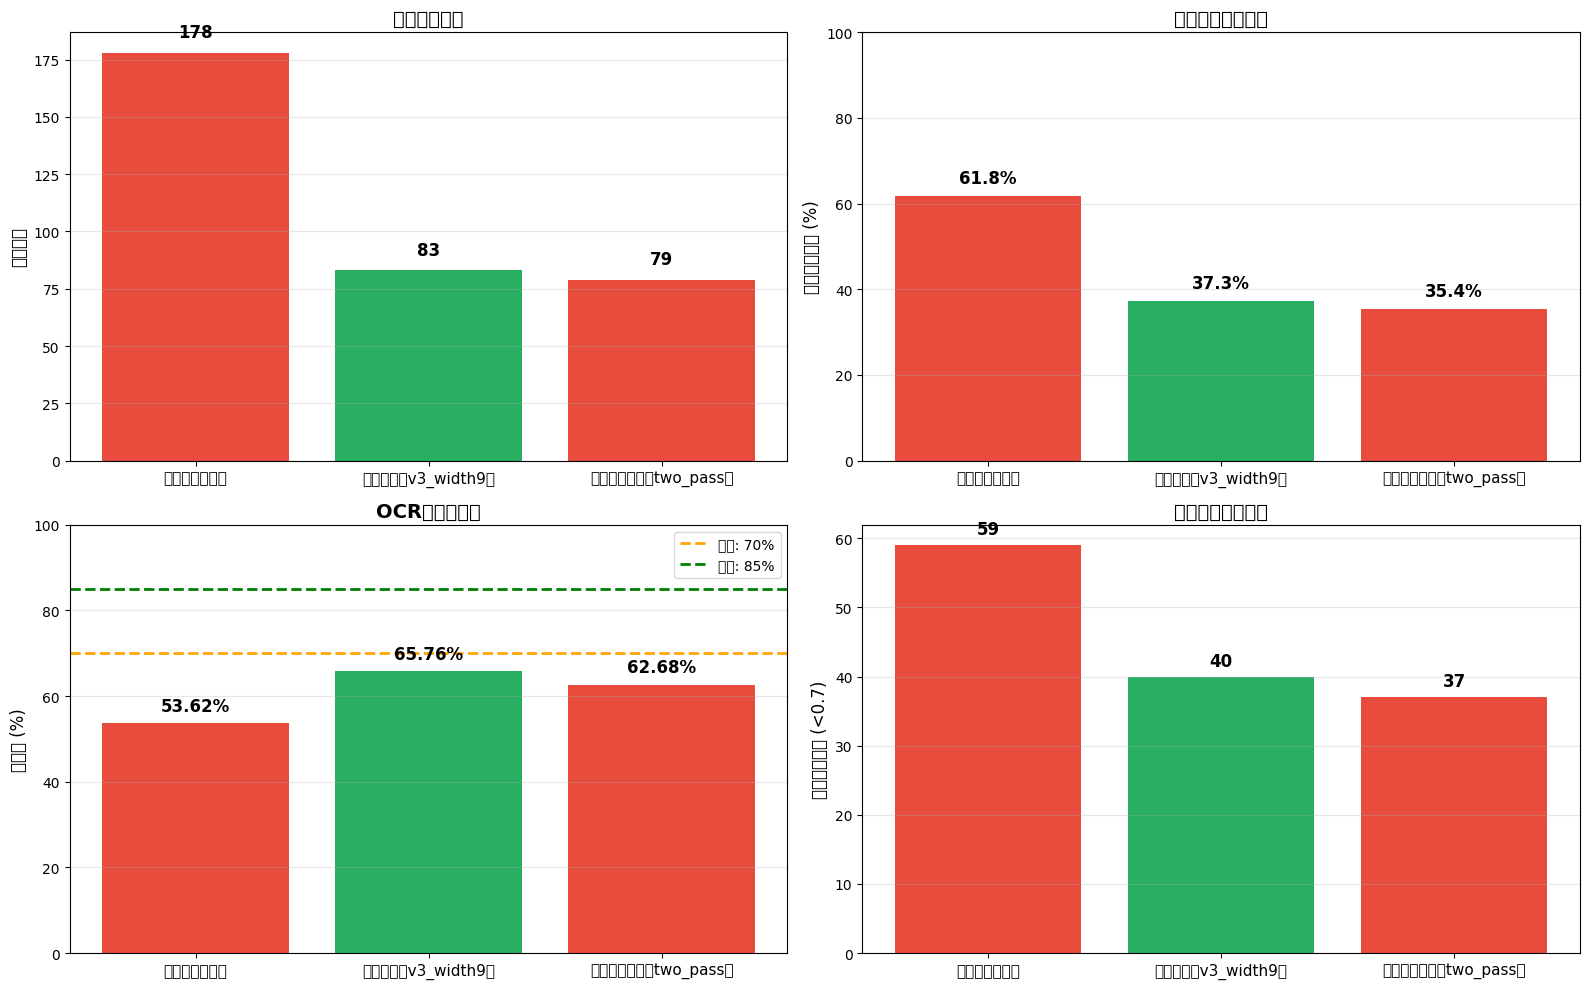

In [24]:
# 可视化对比
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 提取数据
names = list(comparison_results.keys())
colors = ['#e74c3c', '#27ae60']

# 1. 检测框数对比
ax1 = axes[0, 0]
boxes = [comparison_results[name]['num_boxes'] for name in names]
bars1 = ax1.bar(range(len(names)), boxes, color=colors)
ax1.set_xticks(range(len(names)))
ax1.set_xticklabels(names, fontsize=11)
ax1.set_ylabel('检测框数', fontsize=12)
ax1.set_title('检测框数对比', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars1, boxes)):
    ax1.text(i, val + 5, str(val), ha='center', va='bottom', fontsize=12, fontweight='bold')

# 2. 单字符框占比对比
ax2 = axes[0, 1]
single_ratios = [comparison_results[name]['single_char_ratio'] for name in names]
bars2 = ax2.bar(range(len(names)), single_ratios, color=colors)
ax2.set_xticks(range(len(names)))
ax2.set_xticklabels(names, fontsize=11)
ax2.set_ylabel('单字符框占比 (%)', fontsize=12)
ax2.set_title('单字符框占比对比', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars2, single_ratios)):
    ax2.text(i, val + 2, f'{val:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 3. 准确率对比
ax3 = axes[1, 0]
accuracies = [comparison_results[name]['accuracy'] for name in names]
bars3 = ax3.bar(range(len(names)), accuracies, color=colors)
ax3.set_xticks(range(len(names)))
ax3.set_xticklabels(names, fontsize=11)
ax3.set_ylabel('准确率 (%)', fontsize=12)
ax3.set_title('OCR准确率对比', fontsize=14, fontweight='bold')
ax3.set_ylim(0, 100)
ax3.axhline(y=70, color='orange', linestyle='--', linewidth=2, label='目标: 70%')
ax3.axhline(y=85, color='green', linestyle='--', linewidth=2, label='理想: 85%')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars3, accuracies)):
    ax3.text(i, val + 2, f'{val:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 4. 低置信度框对比
ax4 = axes[1, 1]
low_conf_counts = [comparison_results[name]['low_conf_count'] for name in names]
bars4 = ax4.bar(range(len(names)), low_conf_counts, color=colors)
ax4.set_xticks(range(len(names)))
ax4.set_xticklabels(names, fontsize=11)
ax4.set_ylabel('低置信度框数 (<0.7)', fontsize=12)
ax4.set_title('低置信度框数对比', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars4, low_conf_counts)):
    ax4.text(i, val + 1, str(val), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [26]:
# 详细错误分析对比
print("="*80)
print("详细错误分析")
print("="*80)

for name, data in comparison_results.items():
    print(f"\n【{name}】")
    print("-" * 60)
    
    pred_clean = data['text'].replace('\n', '').replace(' ', '')
    
    # 使用difflib分析差异
    matcher = difflib.SequenceMatcher(None, pred_clean, gt_clean)
    
    # 找到最长连续匹配
    match_blocks = matcher.get_matching_blocks()
    if len(match_blocks) > 1:
        longest_match = max(match_blocks[:-1], key=lambda x: x.size)
        print(f"最长连续匹配: {longest_match.size} 个字符")
    
    # 统计编辑操作
    opcodes = matcher.get_opcodes()
    replace_count = sum(1 for op, _, _, _, _ in opcodes if op == 'replace')
    delete_count = sum(1 for op, _, _, _, _ in opcodes if op == 'delete')
    insert_count = sum(1 for op, _, _, _, _ in opcodes if op == 'insert')
    
    print(f"编辑操作统计:")
    print(f"  替换(错误识别): {replace_count}")
    print(f"  删除(识别多余): {delete_count}")
    print(f"  插入(漏识别): {insert_count}")
    print(f"  总操作数: {replace_count + delete_count + insert_count}")
    
    # 显示前200字符对比
    print(f"\n前200字符对比:")
    print(f"Ground Truth: {gt_clean[:200]}")
    print(f"识别结果:     {pred_clean[:200]}")

print("\n" + "="*80)
print("错误分析完成")
print("="*80)

详细错误分析

【原图（有竖线）】
------------------------------------------------------------
最长连续匹配: 13 个字符
编辑操作统计:
  替换(错误识别): 58
  删除(识别多余): 12
  插入(漏识别): 20
  总操作数: 90

前200字符对比:
Ground Truth: 親愛的你：你好！我是一名普通的香港人。首先，請容許我爲自己的俗氣致歉。畢竟我倆素未謀面，再加上我是一名老實人，實在寫不出些精妙絕倫又討好非常的句子，唯有難爲你頂著這俗氣難當的石頭繼續閲讀下去。你或許會問爲甚麽稱你爲「你」。正如我所説，我們素未謀面，我甚至連你叫甚麽我也不知。只是在看完冬奧滑雪比賽後，忽然有感，便匆匆提筆來寫。不過我想，以後的我們一定會熟絡起來的。這年的冬奧與以往五大差別，卻又似有不
识别结果:     親愛的你你好！我名普通的香港葡是先請-T0D素許我為自己的俗氣致歉畢我俩未谋容面上我是一名老寞曾在易不出精妙再加人些唯有難為你頂着又时好非常的句子這纪倫俗難當的勢頭繼續閱讀下去氣你或許會問為甚麼稱你為你正如我所说U們素未謀面，我甚至連你叫甚麼我也不我知是在看完冬奥谓雪比赛忽然有感便只後0以後的我們一定提第来寫不過我想，會匆勿熟络起未的年的冬奥以往無大差這别卻又似有不同在於y相同在於依舊難纏的對手不

【删除竖线（v3_width9）】
------------------------------------------------------------
最长连续匹配: 14 个字符
编辑操作统计:
  替换(错误识别): 64
  删除(识别多余): 9
  插入(漏识别): 23
  总操作数: 96

前200字符对比:
Ground Truth: 親愛的你：你好！我是一名普通的香港人。首先，請容許我爲自己的俗氣致歉。畢竟我倆素未謀面，再加上我是一名老實人，實在寫不出些精妙絕倫又討好非常的句子，唯有難爲你頂著這俗氣難當的石頭繼續閲讀下去。你或許會問爲甚麽稱你爲「你」。正如我所説，我們素未謀面，我甚至連你叫甚麽我也不知。只是在看完冬奧滑雪比賽後，忽然有感，便匆匆提筆來寫。不過我想，以後的我們一定會熟絡起來的。這年的冬奧與以往五大差別，卻又似有不
识别结果:     親愛的你直元你好！我是一名

In [27]:
# 实验结论
print("="*80)
print("实验结论")
print("="*80)

if len(comparison_results) >= 2:
    results_list = list(comparison_results.items())
    original_name, original = results_list[0]
    
    # 找出最佳方法
    best_method_name = original_name
    best_method = original
    for name, data in results_list[1:]:
        if data['accuracy'] > best_method['accuracy']:
            best_method_name = name
            best_method = data
    
    accuracy_improvement = best_method['accuracy'] - original['accuracy']
    
    print(f"\n最佳方法: {best_method_name}")
    print(f"准确率变化: {original['accuracy']:.2f}% → {best_method['accuracy']:.2f}% ({accuracy_improvement:+.2f}%)")
    
    # 如果有多个处理方法，显示对比
    if len(results_list) > 2:
        print(f"\n各方法准确率对比:")
        for name, data in results_list:
            print(f"  {name}: {data['accuracy']:.2f}%")
    
    if best_method['accuracy'] >= 70:
        print("\n✓ 实验成功! 删除竖线显著提升了OCR准确率")
        print(f"  - 达到了70%的目标准确率")
        print(f"  - 单字符框占比从 {original['single_char_ratio']:.1f}% 降至 {best_method['single_char_ratio']:.1f}%")
        print(f"  - 最佳方法: {best_method_name}")
        print(f"  - 建议: 将该方法作为预处理步骤应用到所有图片")
    elif best_method['accuracy'] >= 60:
        print("\n⚠ 实验部分成功: 有提升但未达到目标")
        print(f"  - 准确率提升了 {accuracy_improvement:.2f}%")
        print(f"  - 单字符框占比从 {original['single_char_ratio']:.1f}% 降至 {best_method['single_char_ratio']:.1f}%")
        print(f"  - 最佳方法: {best_method_name}")
        print(f"  - 建议: 结合其他预处理方法或调整OCR参数")
    else:
        print("\n✗ 实验未达预期: 竖线可能不是主要问题")
        print(f"  - 准确率仅提升了 {accuracy_improvement:.2f}%")
        print(f"  - 建议: 尝试其他方法（横线删除、参数调优、不同OCR模型）")
    
    print("\n下一步行动:")
    if best_method['accuracy'] >= 70:
        print(f"  1. 将 {best_method_name} 应用到所有48张图片")
        print("  2. 进入Phase 2: 确定第2页的裁剪坐标")
        print("  3. 进入Phase 3: 批量处理和结果汇总")
    else:
        print("  1. 分析剩余错误的模式")
        print("  2. 尝试删除横线或其他预处理")
        print("  3. 调整OCR参数或尝试其他模型")

else:
    print("\n需要至少两张图片的对比结果才能得出结论")

print("\n" + "="*80)

实验结论

最佳方法: 删除竖线（v3_width9）
准确率变化: 53.62% → 65.76% (+12.14%)

各方法准确率对比:
  原图（有竖线）: 53.62%
  删除竖线（v3_width9）: 65.76%
  两次迭代删除（two_pass）: 62.68%

⚠ 实验部分成功: 有提升但未达到目标
  - 准确率提升了 12.14%
  - 单字符框占比从 61.8% 降至 37.3%
  - 最佳方法: 删除竖线（v3_width9）
  - 建议: 结合其他预处理方法或调整OCR参数

下一步行动:
  1. 分析剩余错误的模式
  2. 尝试删除横线或其他预处理
  3. 调整OCR参数或尝试其他模型



## Phase 3: 统一批量处理 (待实施)

完成Phase 2后，实施批量处理

In [ ]:
# Phase 3 待实施
# 1. 使用最佳参数配置
# 2. 批量处理48张图片（自动选择裁剪区域）
# 3. 保存所有OCR结果
# 4. 生成汇总报告

print("Phase 3 尚未实施")
print("请在完成Phase 1和Phase 2后再继续")